In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster, linkage

def hierarchical_clustering(X):
    linkage_methods = ['ward', 'complete', 'average', 'single']
    best_score = -1
    best_method = None
    best_k = None
    best_Z = None
    best_labels = None
    silhouette_scores = {}

    for method in linkage_methods:
        Z = linkage(X, method=method)
        scores = []
        for k in range(2, 11):
            labels = fcluster(Z, k, criterion='maxclust')
            # Guard (usually not needed, but safe)
            if len(np.unique(labels)) < 2:
                score = -1
            else:
                score = silhouette_score(X, labels)
            scores.append(score)

            if score > best_score:
                best_score = score
                best_method = method
                best_k = k
                best_Z = Z
                best_labels = labels

        silhouette_scores[method] = scores

    # Return the best results + the full silhouette curves per method
    return best_Z, best_method, best_k, silhouette_scores, best_labels

# Example usage
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
linkage_matrix, linkage_method, k, silhouette_scores, labels = hierarchical_clustering(X)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

def plot_best_dendrogram(X, methods=('ward','complete','average','single'),
                         k_range=range(2, 11), show=True):
    """
    Finds the best hierarchical clustering (by silhouette) across linkage methods and k,
    plots the dendrogram with the cutoff that yields the chosen k, and plots silhouette vs k.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data to cluster.
    methods : tuple of str
        Linkage methods to consider.
    k_range : range or iterable of int
        Candidate numbers of clusters.
    show : bool
        If True, display the plots.

    Returns
    -------
    result : dict
        {
          'Z': best linkage matrix,
          'method': best linkage method,
          'k': chosen number of clusters,
          'labels': cluster labels for best solution,
          'best_silhouette': best silhouette score (float),
          'silhouette_curves': {method: [scores over k_range]}
        }
    """
    best = {
        'best_silhouette': -1.0,
        'method': None,
        'k': None,
        'Z': None,
        'labels': None
    }
    silhouette_curves = {}

    # Search methods x k
    for method in methods:
        Z = linkage(X, method=method)
        scores = []
        for k in k_range:
            labels = fcluster(Z, k, criterion='maxclust')
            if len(np.unique(labels)) < 2:
                score = -1.0
            else:
                score = silhouette_score(X, labels)
            scores.append(score)

            if score > best['best_silhouette']:
                best.update({
                    'best_silhouette': score,
                    'method': method,
                    'k': k,
                    'Z': Z,
                    'labels': labels
                })
        silhouette_curves[method] = scores

    # Helper: distance threshold that yields exactly k clusters
    def _distance_cut_for_k(Z, k):
        n = Z.shape[0] + 1
        d = Z[:, 2]
        # After m merges there are n-m clusters; for k clusters m = n-k
        idx = (n - k) - 1
        # Any value between consecutive merge heights gives that k
        return (d[idx] + d[idx + 1]) / 2.0

    # Plot dendrogram with cutoff and silhouette curve for the winning method
    if show:
        t = _distance_cut_for_k(best['Z'], best['k'])

        plt.figure()
        dendrogram(best['Z'], color_threshold=t, no_labels=True)
        plt.axhline(y=t, linestyle='--')
        plt.title(f"Dendrogram (method='{best['method']}') | k={best['k']} | silhouette={best['best_silhouette']:.3f}")
        plt.xlabel("Samples")
        plt.ylabel("Linkage distance")
        plt.show()

        ks = list(k_range)
        plt.figure()
        plt.plot(ks, silhouette_curves[best['method']], marker='o')
        plt.axvline(x=best['k'], linestyle='--')
        plt.title(f"Silhouette vs k (method='{best['method']}') — chosen k={best['k']}")
        plt.xlabel("k (number of clusters)")
        plt.ylabel("Silhouette score")
        plt.show()

    best['silhouette_curves'] = silhouette_curves
    return best


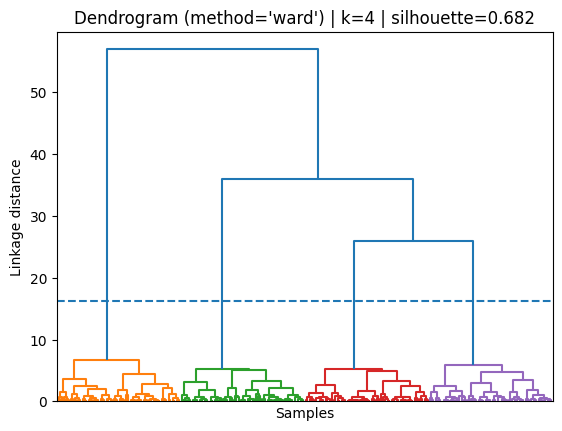

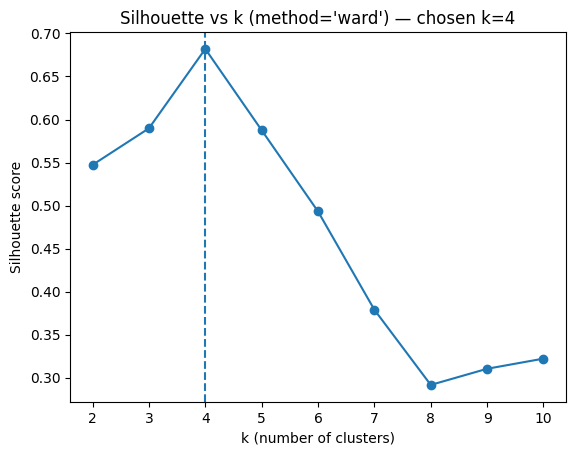

ward 4 0.6819938690643478


In [14]:
result = plot_best_dendrogram(X)
print(result['method'], result['k'], result['best_silhouette'])
